In [4]:
import numpy as np 
import pandas as pd
import os
import gzip
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
dataDir = "../64x/"
dataWaterArr = []
dataMembraneArr = []
dataSystemArr = []

for simDir in os.listdir(dataDir):
    if simDir.startswith('0'):
        waterArr = []
        membraneArr = []
        systemArr = []
        for stepDir in os.listdir(dataDir+simDir):
            if stepDir == "perm":
                currPath = dataDir+simDir+'/'+stepDir+'/'
                for waterFile in os.listdir(currPath+'water/'):
                    waterArr.append(currPath+'water/'+waterFile)
                for membraneFile in os.listdir(currPath+'membrane/'):
                    membraneArr.append(currPath+'membrane/'+membraneFile)
                for systemFile in os.listdir(currPath+'system/'):
                    systemArr.append(currPath+'system/'+systemFile)
        if waterArr:
            dataWaterArr.append(waterArr)
        else:
            print("No water array created for: " + dataDir+simDir)
        if membraneArr:
            dataMembraneArr.append(membraneArr)
        else:
            print("No membrane array created for: " + dataDir+simDir)
        if systemArr:
            dataSystemArr.append(systemArr)
        else:
            print("No system array created for: " + dataDir+simDir)


No system array created for: ../64x/03_90


In [6]:
allWaterDF = []
timesteps = []
for waterArr in dataWaterArr:
    waterDFS = []
    for waterData in waterArr:
        with gzip.open(waterData) as f:
            f.readline().rstrip()
            timestep = f.readline().rstrip().decode("utf-8") 
        print(timestep)
        timesteps.append(timestep)
        idf = pd.read_csv(waterData).iloc[7:,:]
        dfCols = idf.iloc[0,].str.split(' ')[0]
        del dfCols[0:2]
        df = idf.iloc[1:,:]['ITEM: TIMESTEP'].str.split(' ', expand=True)
        df.set_axis(dfCols,axis=1,inplace=True)
        df.reset_index(drop=True, inplace=True)
        df = df.apply(pd.to_numeric)
        waterDFS.append(df)
    allWaterDF.append(waterDFS)  

print(timesteps)
# for membraneArr in dataMembraneArr:
#     for membraneData in membraneArr:
#         print(membraneData)
        
# for systemArr in dataSystemArr:
#     for systemData in systemArr:
#         print(systemData)

['157240000', '157250000', '157260000', '157270000', '157280000', '157290000', '157300000', '157310000', '157320000', '157330000', '157340000', '157350000', '157360000', '157370000', '157380000', '157390000', '157400000', '157410000', '157420000', '157430000', '157440000', '157450000', '157460000', '157470000', '157480000', '157490000', '157500000', '157510000', '157520000', '157530000', '157540000', '157550000', '157560000', '157570000', '157580000', '157590000', '157600000', '157610000', '157620000', '157630000', '157640000', '157650000', '157660000', '157670000', '157680000', '157690000', '157700000', '157710000', '157720000', '157730000', '157740000', '157750000', '157760000', '157770000', '157780000', '157790000', '157800000', '157810000', '157820000', '157830000', '157840000', '157850000', '157860000', '157870000', '157880000', '157890000', '157900000', '157910000', '157920000', '157930000', '157940000', '157950000', '157960000', '157970000', '157980000', '157990000', '158000000'

# Domain info:
## 03_90
Crosslinking degree:

Density

Z start -120

Z stop 120


In [7]:
bin_size = 2
z_min = -280
z_max = 200
x_min = 0
x_max = 175.768279310017
y_min = 0
y_max = 175.768279310017
x_len = x_max - x_min
y_len = y_max - y_min
ang3_to_cm3 = (1e8)**3
avo_num = 6.0221409e+23

In [8]:
i = 0
for dfSet in allWaterDF:
    pressureSeries = []
    kePressureSeries = []
    kspacePressureSeries = []
    fixPressureSeries = []
    densitySeries = []
    volSeries = []
    vxSeries = []
    vySeries = []
    vzSeries = []
    for df in dfSet:
        dfMol = pd.DataFrame()
        df['xmass'] = df['mass'] * df['x']
        df['ymass'] = df['mass'] * df['y']
        df['zmass'] = df['mass'] * df['z']
        df['vxmass'] = df['mass'] * df['vx']
        df['vymass'] = df['mass'] * df['vy']
        df['vzmass'] = df['mass'] * df['vz']
        
        dfMol['mass'] = df['mass'].groupby(df.index // 3).sum()
        dfMol['xmass'] = df['xmass'].groupby(df.index // 3).sum()
        dfMol['ymass'] = df['ymass'].groupby(df.index // 3).sum()
        dfMol['zmass'] = df['zmass'].groupby(df.index // 3).sum()
        dfMol['vxmass'] = df['vxmass'].groupby(df.index // 3).sum()
        dfMol['vymass'] = df['vymass'].groupby(df.index // 3).sum()
        dfMol['vzmass'] = df['vzmass'].groupby(df.index // 3).sum()
        
        dfMol['stressvol'] = df['v_peratompress'].groupby(df.index // 3).sum()
        dfMol['stressvol_ke'] = df['v_peratompresske'].groupby(df.index // 3).sum()
        dfMol['stressvol_kspace'] = df['v_peratompresskspace'].groupby(df.index // 3).sum()
        dfMol['stressvol_fix'] = df['v_peratompressfix'].groupby(df.index // 3).sum()
        dfMol['vol'] = df['c_peratomvol[1]'].groupby(df.index // 3).sum()
        
        dfMol['x'] = dfMol['xmass'] / dfMol['mass']
        dfMol['y'] = dfMol['ymass'] / dfMol['mass']
        dfMol['z'] = dfMol['zmass'] / dfMol['mass']
        dfMol['vx'] = dfMol['vxmass'] / dfMol['mass']
        dfMol['vy'] = dfMol['vymass'] / dfMol['mass']
        dfMol['vz'] = dfMol['vzmass'] / dfMol['mass']
        dfMol['press'] = - dfMol['stressvol'] / (3 * dfMol['vol'])
        dfMol['press_ke'] = - dfMol['stressvol_ke'] / (3 * dfMol['vol'])
        dfMol['press_kspace'] = - dfMol['stressvol_kspace'] / (3 * dfMol['vol'])
        dfMol['press_fix'] = - dfMol['stressvol_fix'] / (3 * dfMol['vol'])
        
        
        dfMol['bin'] = pd.cut(dfMol['z'], range(z_min,z_max,bin_size),labels=False)
        stepDF_mean = dfMol.groupby(['bin'], dropna=False).mean()
        dfMol['density'] = (dfMol['mass'] / (x_len * y_len * bin_size)) * ang3_to_cm3 / avo_num
        stepDF_sum = dfMol.groupby(['bin'], dropna=True).sum()
        
        pressureSeries.append(stepDF_mean['press'].rename(timesteps[i], axis=1))
        kePressureSeries.append(stepDF_mean['press_ke'].rename(timesteps[i], axis=1))
        kspacePressureSeries.append(stepDF_mean['press_kspace'].rename(timesteps[i], axis=1))
        fixPressureSeries.append(stepDF_mean['press_fix'].rename(timesteps[i], axis=1))
        volSeries.append(stepDF_mean['vol'].rename(timesteps[i], axis=1))
        vxSeries.append(stepDF_mean['vx'].rename(timesteps[i], axis=1))
        vySeries.append(stepDF_mean['vy'].rename(timesteps[i], axis=1))
        vzSeries.append(stepDF_mean['vz'].rename(timesteps[i], axis=1))
        densitySeries.append(stepDF_sum['density'].rename(timesteps[i], axis=1))
        i += 1
pressureSeriesDF = pd.concat(pressureSeries, axis=1, ignore_index=False)
kePressureSeriesDF = pd.concat(kePressureSeries, axis=1, ignore_index=False)
kspacePressureSeriesDF = pd.concat(kspacePressureSeries, axis=1, ignore_index=False)
fixPressureSeriesDF = pd.concat(fixPressureSeries, axis=1, ignore_index=False)
volSeriesDF = pd.concat(volSeries, axis=1, ignore_index=False)
vxSeriesDF = pd.concat(vxSeries, axis=1, ignore_index=False)
vySeriesDF = pd.concat(vySeries, axis=1, ignore_index=False)
vzSeriesDF = pd.concat(vzSeries, axis=1, ignore_index=False)
densitySeriesDF = pd.concat(densitySeries, axis=1, ignore_index=False)
# print(pressureSeriesDF.head())
# print(kePressureSeriesDF.head())
# print(kspacePressureSeriesDF.head())
# print(fixPressureSeriesDF.head())

<AxesSubplot:>

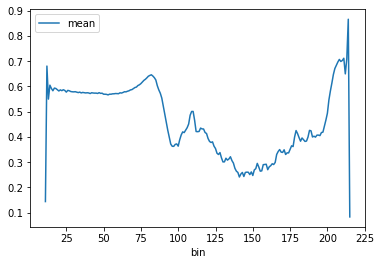

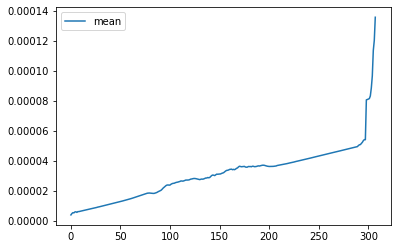

In [10]:
densitySeriesDF['mean'] = densitySeriesDF.mean(axis=1)
densitySeriesDF.plot(y='mean', use_index=True)
density1SeriesDF = pd.read_csv("03_90density.csv")
density1SeriesDF['mean'] = density1SeriesDF.mean(axis=1)
density1SeriesDF['mean'] = density1SeriesDF['mean'] / (x_len * y_len * bin_size)

density1SeriesDF['mean'] = density1SeriesDF['mean'] * ang3_to_cm3 / avo_num
density1SeriesDF.plot(y='mean', use_index=True)

<AxesSubplot:xlabel='bin'>

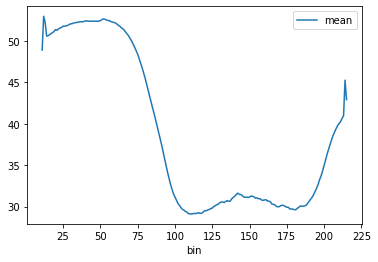

In [9]:
volSeriesDF['mean'] = volSeriesDF.mean(axis=1)
volSeriesDF.to_csv("03_90vol.csv")
volSeriesDF.plot(y='mean', use_index=True)

<AxesSubplot:xlabel='bin'>

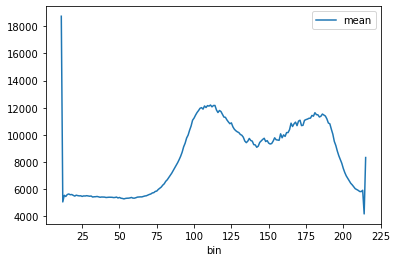

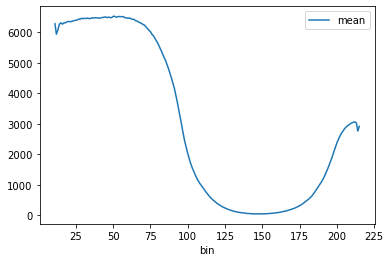

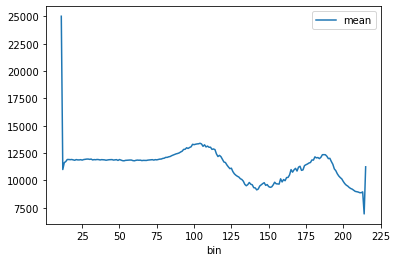

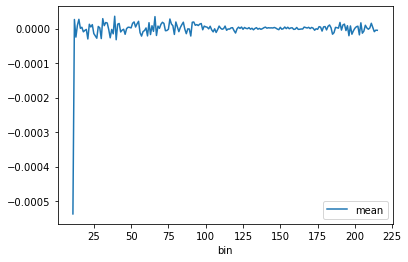

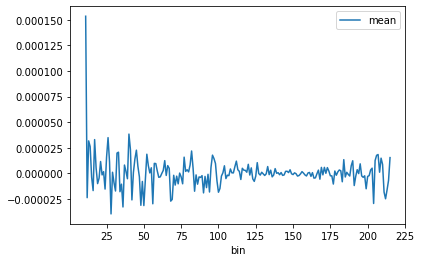

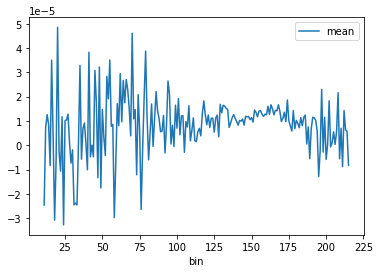

In [11]:
# Plot individual time steps
# average across rows
pressureSeriesDF['mean'] = pressureSeriesDF.mean(axis=1)
kePressureSeriesDF['mean'] = kePressureSeriesDF.mean(axis=1)
kspacePressureSeriesDF['mean'] = kspacePressureSeriesDF.mean(axis=1)
fixPressureSeriesDF['mean'] = fixPressureSeriesDF.mean(axis=1)
vxSeriesDF['mean'] = vxSeriesDF.mean(axis=1)
vySeriesDF['mean'] = vySeriesDF.mean(axis=1)
vzSeriesDF['mean'] = vzSeriesDF.mean(axis=1)

# truePressureSeriesDF = pd.DataFrame(kePressureSeriesDF['mean']+kspacePressureSeriesDF['mean'])
bondPressureSeriesDF = pd.DataFrame(pressureSeriesDF['mean']-(kePressureSeriesDF['mean']+kspacePressureSeriesDF['mean']+fixPressureSeriesDF['mean']))
bondkePressureSeriesDF = pd.DataFrame(pressureSeriesDF['mean']-(kspacePressureSeriesDF['mean']+fixPressureSeriesDF['mean']))

# print(pressureSeriesDF['mean'])
# print(kePressureSeriesDF['mean'])
# print(kspacePressureSeriesDF['mean'])
# print(fixPressureSeriesDF['mean'])
pressureSeriesDF.to_csv("03_90pressure.csv")
kePressureSeriesDF.to_csv("03_90kepressure.csv")
kspacePressureSeriesDF.to_csv("03_90kspacepressure.csv")
fixPressureSeriesDF.to_csv("03_90fixpressure.csv")
# truePressureSeriesDF.to_csv("03_90truepressure.csv")
vxSeriesDF.to_csv("03_90vx.csv")
vySeriesDF.to_csv("03_90vy.csv")
vzSeriesDF.to_csv("03_90vz.csv")


# pressureSeriesDF.plot(y='mean', use_index=True)
bondPressureSeriesDF.plot(y='mean', use_index=True)
kePressureSeriesDF.plot(y='mean', use_index=True)
bondkePressureSeriesDF.plot(y='mean', use_index=True)
# kspacePressureSeriesDF.plot(y='mean', use_index=True)
# fixPressureSeriesDF.plot(y='mean', use_index=True)
# truePressureSeriesDF.plot(y='mean', use_index=True)
vxSeriesDF.plot(y='mean', use_index=True)
vySeriesDF.plot(y='mean', use_index=True)
vzSeriesDF.plot(y='mean', use_index=True)
# determine variance/change in those averages
# see what velocities look like.

#perform similar analyses for membrane based on data avail there

#try to calculate flux as well

In [17]:
# bin by y and x as well?
# see inf we can create a 3D heat map of velocity magnitude in the z divided by (average) magnitude in other directions?

0


In [22]:
allMembraneDF = []
timesteps = []
for membraneArr in dataMembraneArr:
    membraneDFS = []
    for membraneData in membraneArr:
        with gzip.open(membraneData) as f:
            f.readline().rstrip()
            timestep = f.readline().rstrip().decode("utf-8") 
        timesteps.append(timestep)
        idf = pd.read_csv(membraneData).iloc[7:,:]
        dfCols = idf.iloc[0,].str.split(' ')[0]
        del dfCols[0:2]
        df = idf.iloc[1:,:]['ITEM: TIMESTEP'].str.split(' ', expand=True)
        df.set_axis(dfCols,axis=1,inplace=True)
        df.reset_index(drop=True, inplace=True)
        df = df.apply(pd.to_numeric)
        membraneDFS.append(df)
    allMembraneDF.append(membraneDFS)
print(timesteps)

['157240000', '157250000', '157260000', '157270000', '157280000', '157290000', '157300000', '157310000', '157320000', '157330000', '157340000', '157350000', '157360000', '157370000', '157380000', '157390000', '157400000', '157410000', '157420000', '157430000', '157440000', '157450000', '157460000', '157470000', '157480000', '157490000', '157500000', '157510000', '157520000', '157530000', '157540000', '157550000', '157560000', '157570000', '157580000', '157590000', '157600000', '157610000', '157620000', '157630000', '157640000', '157650000', '157660000', '157670000', '157680000', '157690000', '157700000', '157710000', '157720000', '157730000', '157740000', '157750000', '157760000', '157770000', '157780000', '157790000', '157800000', '157810000', '157820000', '157830000', '157840000', '157850000', '157860000', '157870000', '157880000', '157890000', '157900000', '157910000', '157920000', '157930000', '157940000', '157950000', '157960000', '157970000', '157980000', '157990000', '158000000'

In [5]:
bin_size = 2
z_min = -264
z_max = 354

In [28]:
i = 0
for dfSet in allMembraneDF:
    pressureSeries = []
    kePressureSeries = []
    kspacePressureSeries = []
    fixPressureSeries = []
    vxSeries = []
    vySeries = []
    vzSeries = []
    volSeries = []
    densitySeries = []
    for df in dfSet:
        df['press'] = - df['v_peratompress'] / (3 * df['c_peratomvol[1]'])
        df['press_ke'] = - df['v_peratompresske'] / (3 * df['c_peratomvol[1]'])
        df['press_kspace'] = - df['v_peratompresskspace'] / (3 * df['c_peratomvol[1]'])
        df['press_fix'] = - df['v_peratompressfix'] / (3 * df['c_peratomvol[1]'])
        df['density'] = (df['mass'] / (x_len * y_len * bin_size)) * ang3_to_cm3 / avo_num
        
        df['bin'] = pd.cut(df['z'], range(z_min,z_max,bin_size),labels=False)
        stepDF = df.groupby(['bin'], dropna=False).sum()
        
        

        
        pressureSeries.append(stepDF['press'].rename(timesteps[i], axis=1))
        kePressureSeries.append(stepDF['press_ke'].rename(timesteps[i], axis=1))
        kspacePressureSeries.append(stepDF['press_kspace'].rename(timesteps[i], axis=1))
        fixPressureSeries.append(stepDF['press_fix'].rename(timesteps[i], axis=1))
        densitySeries.append(stepDF['density'].rename(timesteps[i], axis=1))
#         vxSeries.append(stepDF['vx'].rename(timesteps[i], axis=1))
#         vySeries.append(stepDF['vy'].rename(timesteps[i], axis=1))
#         vzSeries.append(stepDF['vz'].rename(timesteps[i], axis=1))
        i += 1
pressureSeriesDF = pd.concat(pressureSeries, axis=1, ignore_index=False)
kePressureSeriesDF = pd.concat(kePressureSeries, axis=1, ignore_index=False)
kspacePressureSeriesDF = pd.concat(kspacePressureSeries, axis=1, ignore_index=False)
fixPressureSeriesDF = pd.concat(fixPressureSeries, axis=1, ignore_index=False)
densitySeriesDF = pd.concat(densitySeries, axis=1, ignore_index=False)
# vxSeriesDF = pd.concat(vxSeries, axis=1, ignore_index=False)
# vySeriesDF = pd.concat(vySeries, axis=1, ignore_index=False)
# vzSeriesDF = pd.concat(vzSeries, axis=1, ignore_index=False)
# print(pressureSeriesDF.head())
# print(kePressureSeriesDF.head())
# print(kspacePressureSeriesDF.head())
# print(fixPressureSeriesDF.head())

<AxesSubplot:xlabel='bin'>

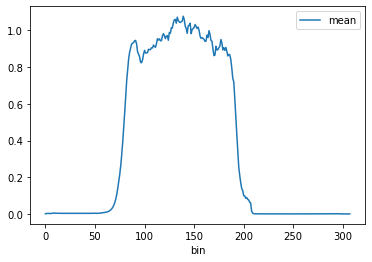

In [6]:
densitySeriesDF['mean'] = densitySeriesDF.mean(axis=1)
densitySeriesDF.plot(y='mean', use_index=True)

<AxesSubplot:xlabel='bin'>

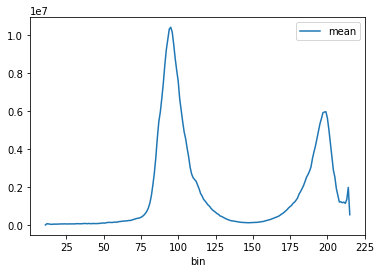

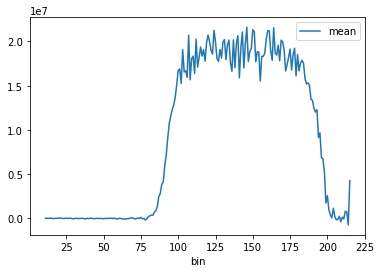

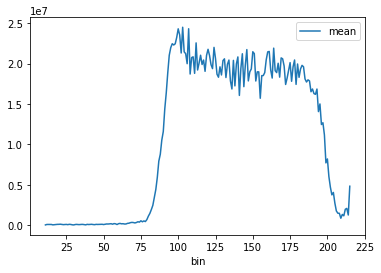

In [33]:
# Plot individual time steps
# average across rows
pressureSeriesDF['mean'] = pressureSeriesDF.mean(axis=1)
kePressureSeriesDF['mean'] = kePressureSeriesDF.mean(axis=1)
kspacePressureSeriesDF['mean'] = kspacePressureSeriesDF.mean(axis=1)
fixPressureSeriesDF['mean'] = fixPressureSeriesDF.mean(axis=1)
# vxSeriesDF['mean'] = vxSeriesDF.mean(axis=1)
# vySeriesDF['mean'] = vySeriesDF.mean(axis=1)
# vzSeriesDF['mean'] = vzSeriesDF.mean(axis=1)
# truePressureSeriesDF = pd.DataFrame(kePressureSeriesDF['mean']+kspacePressureSeriesDF['mean'])
bondPressureSeriesDF = pd.DataFrame(pressureSeriesDF['mean']-(kePressureSeriesDF['mean']+kspacePressureSeriesDF['mean']+fixPressureSeriesDF['mean']))
bondkePressureSeriesDF = pd.DataFrame(pressureSeriesDF['mean']-(kspacePressureSeriesDF['mean']+fixPressureSeriesDF['mean']))
# print(pressureSeriesDF['mean'])
# print(kePressureSeriesDF['mean'])
# print(kspacePressureSeriesDF['mean'])
# print(fixPressureSeriesDF['mean'])
pressureSeriesDF.to_csv("03_90pressure_membrane.csv")
kePressureSeriesDF.to_csv("03_90kepressure_membrane.csv")
bondkePressureSeriesDF.to_csv("03_90bondkepressure_membrane.csv")
bondPressureSeriesDF.to_csv("03_90bondpressure_membrane.csv")
kspacePressureSeriesDF.to_csv("03_90kspacepressure_membrane.csv")
fixPressureSeriesDF.to_csv("03_90fixpressure_membrane.csv")
# truePressureSeriesDF.to_csv("03_90truepressure_membrane.csv")
vxSeriesDF.to_csv("03_90vx_membrane.csv")
vySeriesDF.to_csv("03_90vy_membrane.csv")
vzSeriesDF.to_csv("03_90vz_membrane.csv")

# pressureSeriesDF.plot(y='mean', use_index=True)
kePressureSeriesDF.plot(y='mean', use_index=True)
bondPressureSeriesDF.plot(y='mean', use_index=True)
# kspacePressureSeriesDF.plot(y='mean', use_index=True)
# fixPressureSeriesDF.plot(y='mean', use_index=True)
bondkePressureSeriesDF.plot(y='mean', use_index=True)
# bondPressureSeriesDF.plot(y='mean', use_index=True)
# vxSeriesDF.plot(y='mean', use_index=True)
# vySeriesDF.plot(y='mean', use_index=True)
# vzSeriesDF.plot(y='mean', use_index=True)
# determine variance/change in those averages
# see what velocities look like.

#perform similar analyses for membrane based on data avail there

#try to calculate flux as well

In [24]:
 def pressurePlot(df,title,filename):
    df['z'] = df.index * bin_size
    df['mean'] = df['mean'] / df['mean'].iloc[11:50].mean()
#     print(df['mean'].iloc[11:50].mean())
#     print(df['mean'].iloc[225:375].mean())
    ax = df.plot(x='z', y='mean')
    ax.set_title(title)
    ax.set_xlabel('Distance in direction (z) of flow (angstrom)')
    ax.set_ylabel('Normalized pressure (-)')
    ax.grid(b=True)
    ax.set_ylim(0,1.5)
    ax.legend().remove()
    plt.savefig(filename,bbox_inches='tight')

    
def volPlot(df,title,filename):
    df['z'] = df.index * bin_size
    df['mean'] = df['mean'] / df['mean'].iloc[11:50].mean()
#     print(df['mean'].iloc[11:50].mean())
#     print(df['mean'].iloc[225:375].mean())
    ax = df.plot(x='z', y='mean')
    ax.set_title(title)
    ax.set_xlabel('Distance in direction (z) of flow (angstrom)')
    ax.set_ylabel('Normalized volume (-)')
    ax.grid(b=True)
    ax.legend().remove()
    plt.savefig(filename,bbox_inches='tight')
    
def stressVolPlot(df,title,filename):
    df['z'] = df.index * bin_size
    df['mean'] = df['mean'] / df['mean'].iloc[11:50].mean()
#     print(df['mean'].iloc[11:50].mean())
#     print(df['mean'].iloc[225:375].mean())
    ax = df.plot(x='z', y='mean')
    ax.set_title(title)
    ax.set_xlabel('Distance in direction (z) of flow (angstrom)')
    ax.set_ylabel('Normalized stress-vol (-)')
    ax.grid(b=True)
    ax.legend().remove()
    plt.savefig(filename,bbox_inches='tight')
    
def membranePressurePlot(df,title,filename):
    df['z'] = df.index * bin_size
    df['mean'] = df['mean'] / max(df['mean'].iloc[df.idxmax(axis=0)['mean']],abs(df['mean'].iloc[df.idxmin(axis=0)['mean']]))
    ax = df.plot(x='z', y='mean')
    ax.set_title(title)
    ax.set_xlabel('Distance in direction (z) of flow (angstrom)')
    ax.set_ylabel('Normalized pressure (-)')
    ax.grid(b=True)
    ax.legend().remove()
    plt.savefig(filename,bbox_inches='tight')
    
def velocityPlot(df,title,filename):
    df['z'] = df.index * bin_size
    ax = df.plot(x='z', y='mean')
    ax.set_title(title)
    ax.set_xlabel('Distance in direction (z) of flow (angstrom)')
    ax.set_ylabel('Velocity (angstrom/fs)')
    ax.set_ylim(-2e-4,2e-4)
    ax.grid(b=True)
    ax.legend().remove()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
    plt.savefig(filename,bbox_inches='tight')
    
def membraneVelocityPlot(df,title,filename):
    df['z'] = df.index * bin_size
    ax = df.plot(x='z', y='mean')
    ax.set_title(title)
    ax.set_xlabel('Distance in direction (z) of flow (angstrom)')
    ax.set_ylabel('Velocity (angstrom/fs)')
    ax.legend().remove()
    ax.set_ylim(-4e-3,4e-3)
    ax.grid(b=True)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
    plt.savefig(filename,bbox_inches='tight')

# Plotting from saved files

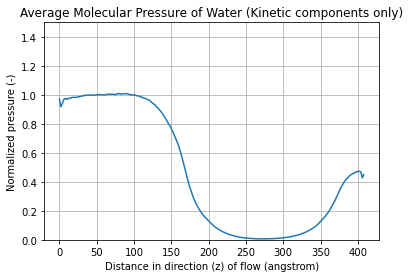

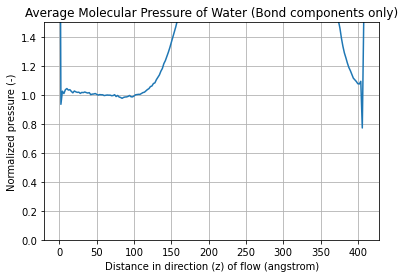

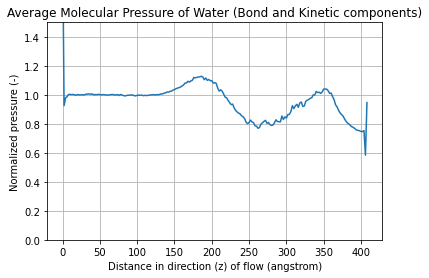

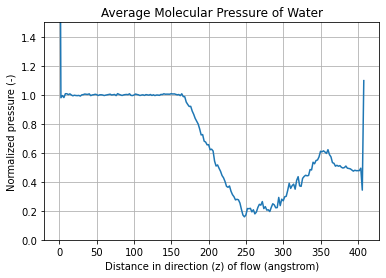

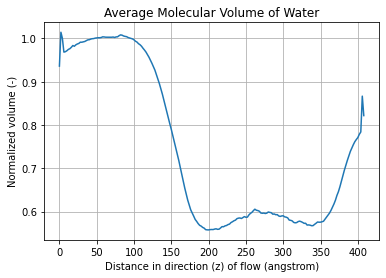

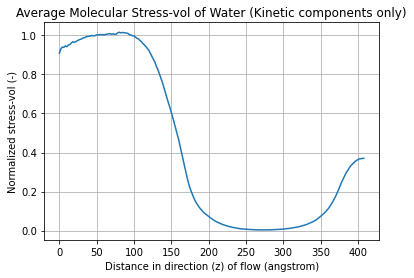

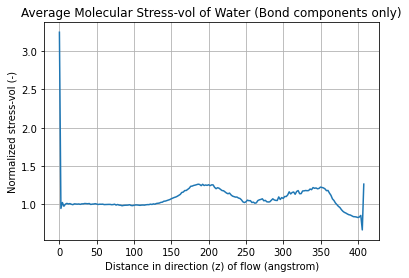

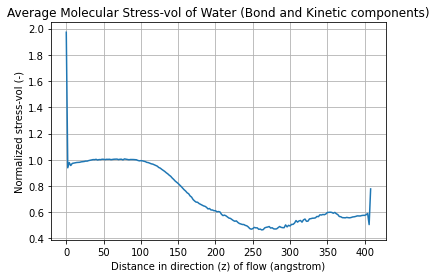

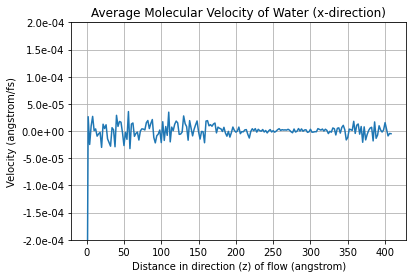

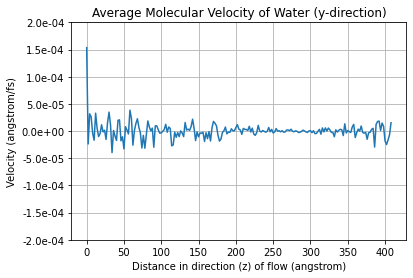

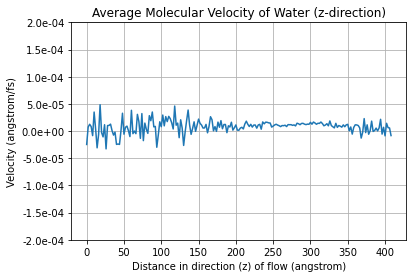

In [25]:
water_pressureSeriesDF = pd.read_csv("03_90pressure.csv")
water_kePressureSeriesDF = pd.read_csv("03_90kepressure.csv")
water_kspacePressureSeriesDF = pd.read_csv("03_90kspacepressure.csv")
water_fixPressureSeriesDF = pd.read_csv("03_90fixpressure.csv")
water_volSeriesDF = pd.read_csv("03_90vol.csv")
water_vxSeriesDF = pd.read_csv("03_90vx.csv")
water_vySeriesDF = pd.read_csv("03_90vy.csv")
water_vzSeriesDF = pd.read_csv("03_90vz.csv")

water_bondPressureSeriesDF = pd.DataFrame(water_pressureSeriesDF['mean']-(water_kePressureSeriesDF['mean']+water_kspacePressureSeriesDF['mean']+water_fixPressureSeriesDF['mean']))
water_bondkePressureSeriesDF = pd.DataFrame(water_pressureSeriesDF['mean']-(water_kspacePressureSeriesDF['mean']+water_fixPressureSeriesDF['mean']))
water_bondPressureSeriesDF.to_csv("03_90bondpressure.csv")
water_bondkePressureSeriesDF.to_csv("03_90bondkepressure.csv")

water_keStressVolSeriesDF = pd.DataFrame(water_kePressureSeriesDF * (3 * water_volSeriesDF))
water_bondStressVolSeriesDF = pd.DataFrame(water_bondPressureSeriesDF * (3 * water_volSeriesDF))
water_bondkeStressVolSeriesDF = pd.DataFrame(water_bondkePressureSeriesDF * (3 * water_volSeriesDF))

pressurePlot(water_kePressureSeriesDF,\
             'Average Molecular Pressure of Water (Kinetic components only)', \
             './plots/03_90water_kepressure.png')
pressurePlot(water_bondPressureSeriesDF,\
             'Average Molecular Pressure of Water (Bond components only)', \
             './plots/03_90water_bondpressure.png')
pressurePlot(water_bondkePressureSeriesDF,\
             'Average Molecular Pressure of Water (Bond and Kinetic components)', \
             './plots/03_90water_bondkepressure.png')

pressurePlot(water_pressureSeriesDF,\
             'Average Molecular Pressure of Water', \
             './plots/03_90water_bondkepressure.png')

volPlot(water_volSeriesDF,\
             'Average Molecular Volume of Water', \
             './plots/03_90water_vol.png')

stressVolPlot(water_keStressVolSeriesDF,\
             'Average Molecular Stress-vol of Water (Kinetic components only)', \
             './plots/03_90water_keStressVol.png')
stressVolPlot(water_bondStressVolSeriesDF,\
             'Average Molecular Stress-vol of Water (Bond components only)', \
             './plots/03_90water_bondStressVol.png')
stressVolPlot(water_bondkeStressVolSeriesDF,\
             'Average Molecular Stress-vol of Water (Bond and Kinetic components)', \
             './plots/03_90water_bondkeStressVol.png')

velocityPlot(water_vxSeriesDF,\
             'Average Molecular Velocity of Water (x-direction)', \
             './plots/03_90water_vx.png')
velocityPlot(water_vySeriesDF,\
             'Average Molecular Velocity of Water (y-direction)', \
             './plots/03_90water_vy.png')
velocityPlot(water_vzSeriesDF,\
             'Average Molecular Velocity of Water (z-direction)', \
             './plots/03_90water_vz.png')

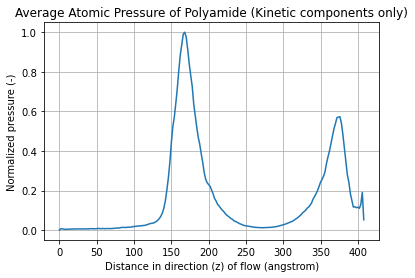

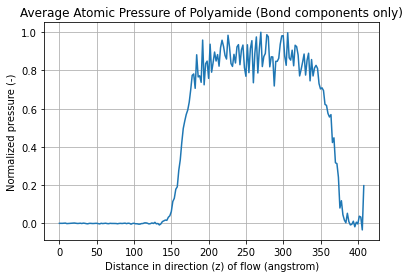

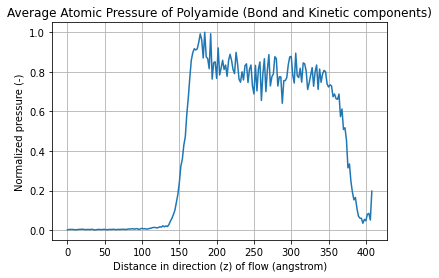

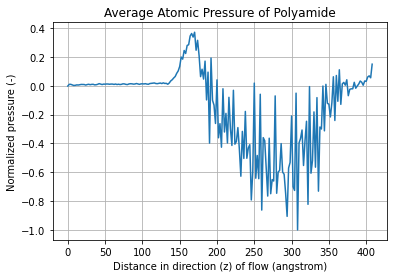

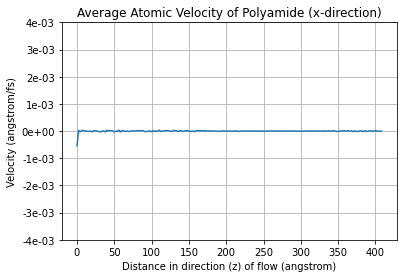

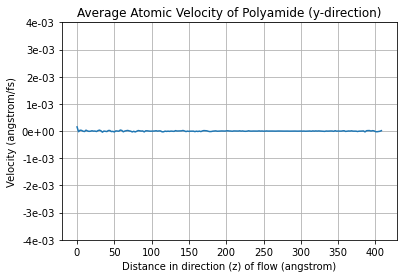

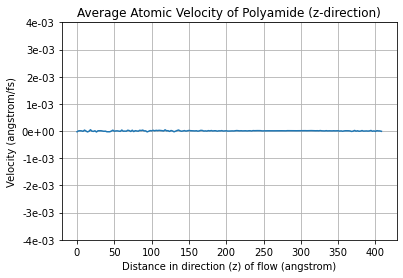

In [34]:
membrane_kePressureSeriesDF = pd.read_csv("03_90kepressure_membrane.csv")
membrane_bondkePressureSeriesDF = pd.read_csv("03_90bondkepressure_membrane.csv")
membrane_pressureSeriesDF = pd.read_csv("03_90pressure_membrane.csv")
membrane_bondPressureSeriesDF = pd.read_csv("03_90bondpressure_membrane.csv")
membrane_vxSeriesDF = pd.read_csv("03_90vx_membrane.csv")
membrane_vySeriesDF = pd.read_csv("03_90vy_membrane.csv")
membrane_vzSeriesDF = pd.read_csv("03_90vz_membrane.csv")

membranePressurePlot(membrane_kePressureSeriesDF,\
             'Average Atomic Pressure of Polyamide (Kinetic components only)', \
             './plots/03_90membrane_kepressure.png')
membranePressurePlot(membrane_bondPressureSeriesDF,\
             'Average Atomic Pressure of Polyamide (Bond components only)', \
             './plots/03_90membrane_bondpressure.png')
membranePressurePlot(membrane_bondkePressureSeriesDF,\
             'Average Atomic Pressure of Polyamide (Bond and Kinetic components)', \
             './plots/03_90membrane_bondkepressure.png')

membranePressurePlot(membrane_pressureSeriesDF,\
             'Average Atomic Pressure of Polyamide', \
             './plots/03_90membrane_pressure.png')

membraneVelocityPlot(membrane_vxSeriesDF,\
             'Average Atomic Velocity of Polyamide (x-direction)', \
             './plots/03_90membrane_vx.png')
membraneVelocityPlot(membrane_vySeriesDF,\
             'Average Atomic Velocity of Polyamide (y-direction)', \
             './plots/03_90membrane_vy.png')
membraneVelocityPlot(membrane_vzSeriesDF,\
             'Average Atomic Velocity of Polyamide (z-direction)', \
             './plots/03_90membrane_vz.png')